# Chapter 6: Quantum Annealing Strategy

Introduction to quantum annealing using D-Wave systems and QUBO formulations.

---

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_Software.ipynb` for installation instructions


In [ ]:
# Setup and imports for D-Wave
import numpy as np
import matplotlib.pyplot as plt
import neal
from pyqubo import Binary, Array,Placeholder
from dimod.reference.samplers import ExactSolver
import networkx as nx
import openjij as oj
from dimod import BinaryQuadraticModel
from Chapter03_EngineeringOptimization_functions import (truss1x1,truss1x2,truss2x2,TrussFEM)
from Chapter05_QuantumAnnealing_functions import QATrussOptimizer, create_max_cut_hard_instance, create_frustrated_spin_glass



##  A 3-variable QUBO problem using an exact solver.

$$ \min_{\{a,b,c\}}  (0.6 a b +0.2 a c + 0.03 b c - 0.1 a - 0.5 b - 0.2c ) $$

In [2]:
a,b,c = Binary("a"), Binary("b"),Binary("c")
H  = 0.6*a*b +0.2*a*c + 0.03*b*c -0.1*a - 0.5*b -0.2*c
model = H.compile()
bqm = model.to_bqm()
# using exact solver for small problems
sampler = ExactSolver() 
results = sampler.sample(bqm)
print(results)

   a  b  c energy num_oc.
6  0  1  1  -0.67       1
7  0  1  0   -0.5       1
1  0  0  1   -0.2       1
2  1  0  1   -0.1       1
3  1  0  0   -0.1       1
0  0  0  0    0.0       1
4  1  1  0    0.0       1
5  1  1  1   0.03       1
['BINARY', 8 rows, 8 samples, 3 variables]


## Max-cut graph QUBO problem using Exact solver

In [3]:
G = nx.Graph() # convenient
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])
H = 0
q = Array.create("q",shape = 5,vartype = "BINARY")
for i, j in G.edges:# create H from graph
    H = H + 2*q[i-1]*q[j-1] - q[i-1] - q[j-1] # offset by 1

model = H.compile()
bqm = model.to_bqm()
# using exact solver for small problems
exact_sampler = ExactSolver()  
results = exact_sampler.sample(bqm)
print(results)

   q[0] q[1] q[2] q[3] q[4] energy num_oc.
8     1    0    0    1    0   -5.0       1
9     1    0    0    1    1   -5.0       1
28    0    1    1    0    0   -5.0       1
29    0    1    1    0    1   -5.0       1
6     1    0    0    0    1   -4.0       1
11    1    0    1    1    0   -4.0       1
12    0    0    1    1    0   -4.0       1
19    0    1    1    1    0   -4.0       1
25    1    1    0    0    1   -4.0       1
30    0    1    0    0    1   -4.0       1
2     0    0    1    0    1   -3.0       1
3     0    0    1    0    0   -3.0       1
4     1    0    1    0    0   -3.0       1
5     1    0    1    0    1   -3.0       1
14    0    0    0    1    1   -3.0       1
15    0    0    0    1    0   -3.0       1
16    0    1    0    1    0   -3.0       1
17    0    1    0    1    1   -3.0       1
22    1    1    0    1    1   -3.0       1
23    1    1    0    1    0   -3.0       1
26    1    1    1    0    1   -3.0       1
27    1    1    1    0    0   -3.0       1
1     0    

##  Solve using Simulated Annealing

In [4]:
SA_sampler = neal.SimulatedAnnealingSampler()
results = SA_sampler.sample(bqm)
print(results)

  q[0] q[1] q[2] q[3] q[4] energy num_oc.
0    1    0    0    1    0   -5.0       1
['BINARY', 1 rows, 1 samples, 5 variables]


## Simulated quantum annealing

In [5]:
# --- METHOD B: Simulated Quantum Annealing (Tunneling) ---
# OpenJij uses "Trotter slices" to simulate quantum tunneling
SQA_sampler = oj.SQASampler()
# Extract Q matrix as dictionary
Q, offset = bqm.to_qubo()
print("Q matrix (dictionary):")
print(Q)
print(f"\nOffset: {offset}")

SQA_sampleset = SQA_sampler.sample_qubo(Q, num_reads=10)

print("--- Simulated Quantum Annealing Results ---")
# Convert to clean dictionary
solution = {k: int(v) for k, v in SQA_sampleset.first.sample.items()}
print(f"Solution: {solution}")
print(f"Energy:   {SQA_sampleset.first.energy:.4f}")
print("=" * 60)

Q matrix (dictionary):
{('q[2]', 'q[4]'): np.float64(2.0), ('q[0]', 'q[2]'): np.float64(2.0), ('q[3]', 'q[4]'): np.float64(2.0), ('q[3]', 'q[2]'): np.float64(2.0), ('q[1]', 'q[0]'): np.float64(2.0), ('q[1]', 'q[3]'): np.float64(2.0), ('q[4]', 'q[4]'): np.float64(-2.0), ('q[2]', 'q[2]'): np.float64(-3.0), ('q[0]', 'q[0]'): np.float64(-2.0), ('q[3]', 'q[3]'): np.float64(-3.0), ('q[1]', 'q[1]'): np.float64(-2.0)}

Offset: 0.0
--- Simulated Quantum Annealing Results ---
Solution: {'q[0]': 0, 'q[1]': 1, 'q[2]': 1, 'q[3]': 0, 'q[4]': 0}
Energy:   -5.0000


## QUBO problem with multiple minima

In [48]:
import neal
import openjij as oj

N = 20
Q = {}

# 1. THE TRAP (False Goal)
# Bits 1 to 19 are slightly attractive on their own.
# System will want to turn these ON, reaching energy ~ -40.
for i in range(1, N):
    Q[(i, i)] = -2.0

# 2. THE SPIKE (The Wall)
# Bit 0 is EXTREMELY expensive to turn on (+1000).
Q[(0, 0)] = 1000.0

# 3. THE TRUE GOAL (Global Minimum)
# ONLY if Bit 0 is ON, the other bits become massively attractive.
# Energy of True Goal (all 1s) will be ~ -1800.
for i in range(1, N):
    Q[(0, i)] = -150.0

# 4. RUN SA with restricted "time" (sweeps)
# SA gets stuck in the -40 trap because it can't jump the +1000 wall.
sa_sampler = neal.SimulatedAnnealingSampler()
sa_results = sa_sampler.sample_qubo(Q, num_reads=100, num_sweeps=10)

# 5. RUN SQA with "Quantumness"
# SQA can tunnel from the trap (-40) to the goal (-1800).
sqa_sampler = oj.SQASampler()
sqa_results = sqa_sampler.sample_qubo(Q, num_reads=100, num_sweeps=10, trotter=50)

def analyze(sampleset, name):
    # Success is reaching the deep True Goal (all 1s)
    successes = sum(1 for s in sampleset.samples() if sum(s.values()) == N)
    print(f"{name:30} -> Successes: {successes:3}/100 | Best Energy: {sampleset.first.energy}")

print("--- The 20-Bit Trap Challenge ---")
analyze(sa_results, "Simulated Annealing")
analyze(sqa_results, "Simulated Quantum Annealing")

--- The 20-Bit Trap Challenge ---
Simulated Annealing            -> Successes: 100/100 | Best Energy: -1888.0
Simulated Quantum Annealing    -> Successes: 100/100 | Best Energy: -1888.0


##  Solve a constrained graph problem 
Via the Lagrangian multiplier, using an Exact QUBO solver.

In [7]:
G = nx.Graph() # convenient
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])
H = 0
q = Array.create("q",shape = 5,vartype = "BINARY")
for i, j in G.edges:# create H from graph
    H = H + 2*q[i-1]*q[j-1] - q[i-1] - q[j-1] # offset by 1
lam = 100
H = H + lam*(q[0] + q[3]-1)**2
model = H.compile()
bqm = model.to_bqm()
# using exact solver for small problems
sampler = ExactSolver()  
results = sampler.sample(bqm)
print(results)

   q[0] q[1] q[2] q[3] q[4] energy num_oc.
4     0    0    1    1    0   -4.0       1
14    1    0    0    0    1   -4.0       1
17    1    1    0    0    1   -4.0       1
27    0    1    1    1    0   -4.0       1
2     1    0    1    0    0   -3.0       1
7     0    0    0    1    0   -3.0       1
8     0    0    0    1    1   -3.0       1
13    1    0    1    0    1   -3.0       1
18    1    1    1    0    1   -3.0       1
23    0    1    0    1    1   -3.0       1
24    0    1    0    1    0   -3.0       1
29    1    1    1    0    0   -3.0       1
1     1    0    0    0    0   -2.0       1
11    0    0    1    1    1   -2.0       1
20    0    1    1    1    1   -2.0       1
30    1    1    0    0    0   -2.0       1
6     1    0    0    1    0   95.0       1
9     1    0    0    1    1   95.0       1
19    0    1    1    0    1   95.0       1
28    0    1    1    0    0   95.0       1
5     1    0    1    1    0   96.0       1
16    0    1    0    0    1   96.0       1
3     0    

## QUBO truss optimization

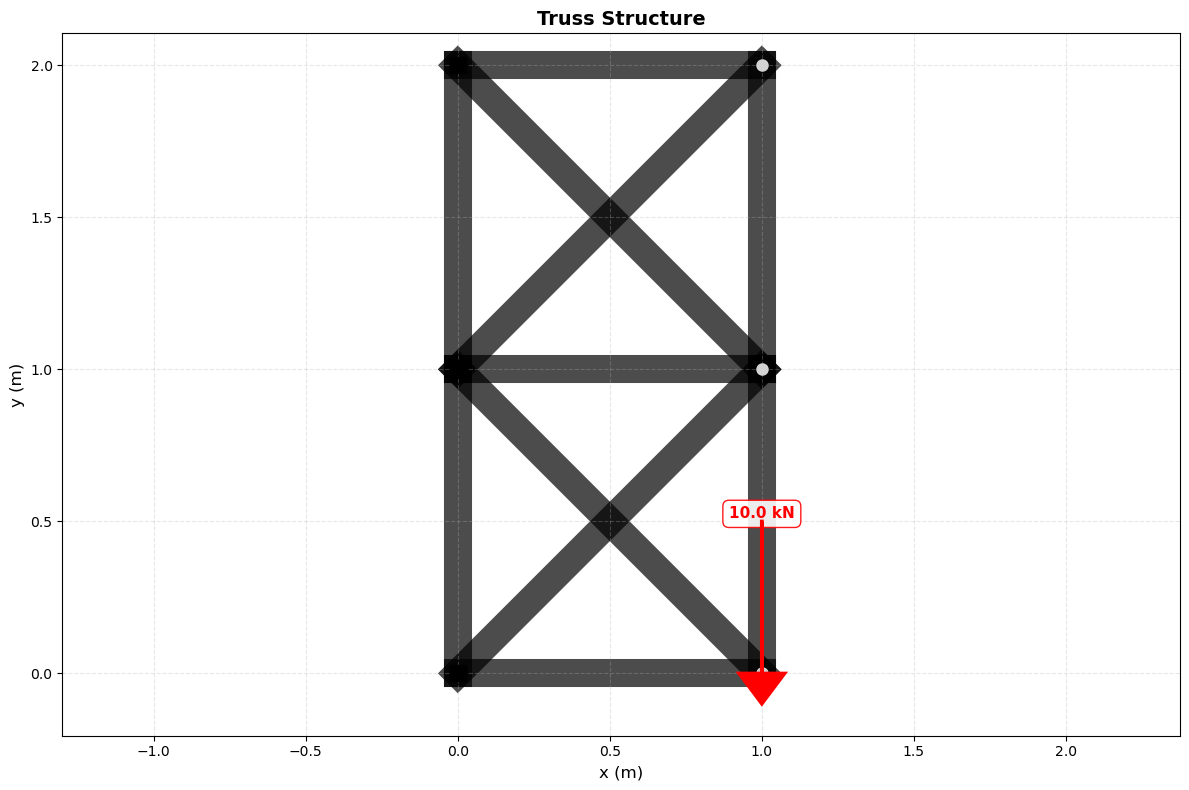

Initial design: Volume = 6.3284, Max Stress = 12928.9322


In [8]:
A0 = 0.5  # Initial cross-sectional area in m^2
fem_model = truss1x2(E=200e9, A=A0) # 
fem_model.plot_truss()
fem_model.solve()
metrics = fem_model.evaluate_design()
V0 = metrics['volume']

print(f"Initial design: Volume = {metrics['volume']:.4f}, Max Stress = {metrics['max_stress']:.4f}")




## QUBO Optimization

QUANTUM ANNEALING TOPOLOGY OPTIMIZATION
Problem: 11 elements
Target volume: 1.5821 m³
Initial areas: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]

OPTIMIZATION COMPLETE
Total iterations: 50
Total time: 7.08s (0.142s per iteration)

Final Design:
  Compliance: 2.8730e-03 J
  Volume: 1.5874 m³ (target: 1.5821)
  Active members: 11/11
  Area range: [3.1495e-03, 3.8891e-01] m²
  Feasible: False


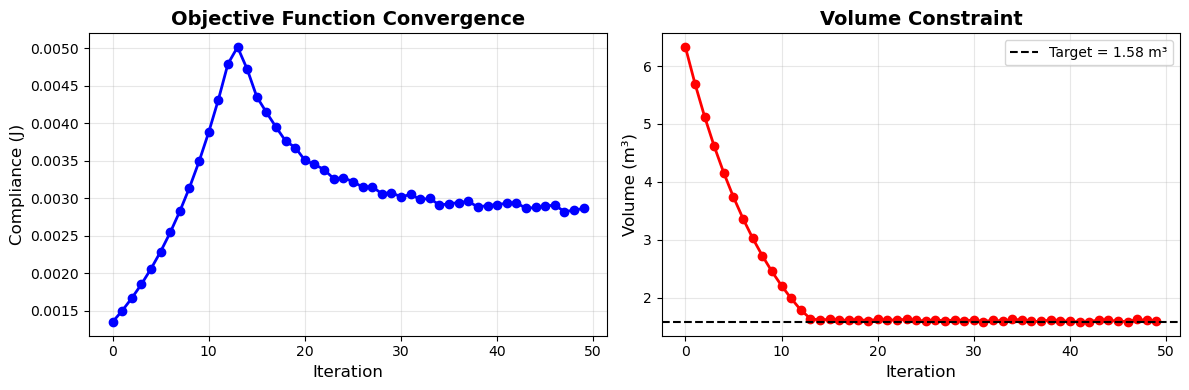

In [9]:
trussQA = QATrussOptimizer(
        fem_model=fem_model,
        V_bar= 0.25*V0, 
    )

# Run optimization
results = trussQA.optimize()

trussQA.plot_convergence()

## Optimized truss

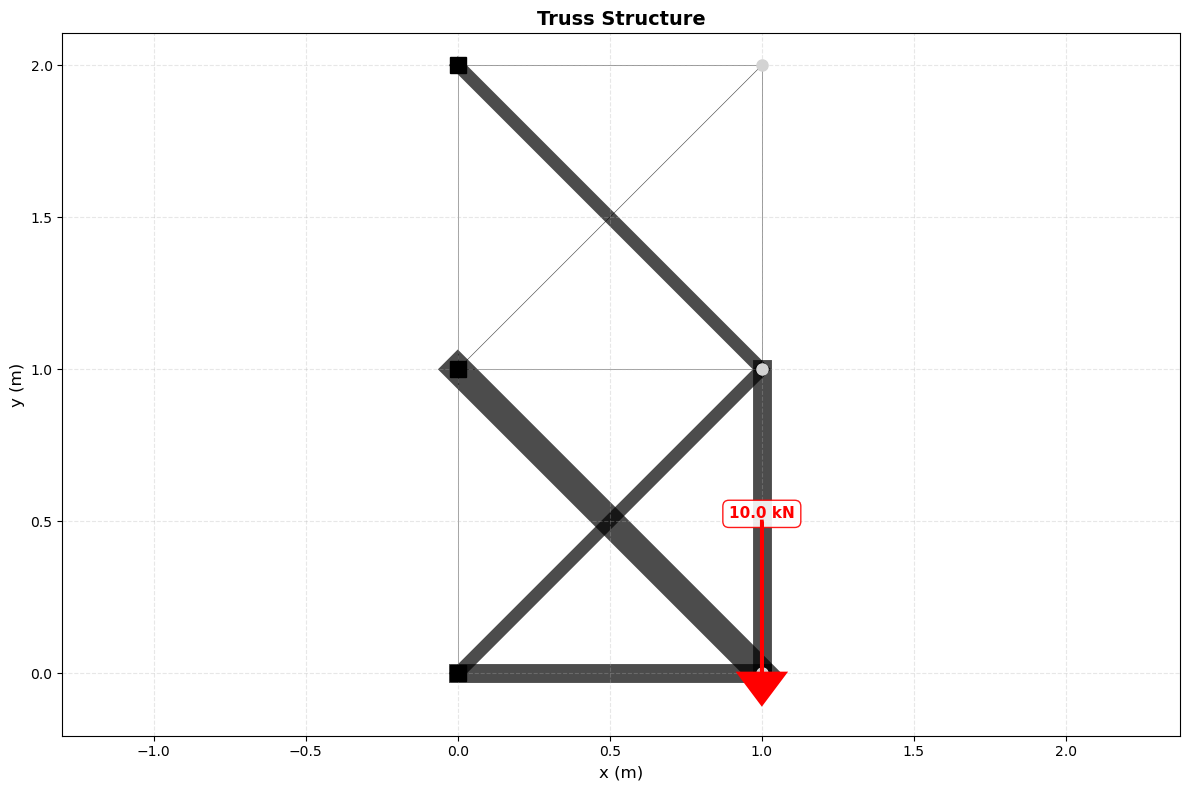

In [10]:
fem_model.plot_truss()